In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

#### Config File

In [2]:
RAW_PATH = "../data/raw/"
PROCESSED_PATH = "../data/processed/"

#### Utils file

In [3]:
import joblib as pkl
import os

def pickle(value = None, filename = None):
    if (value and filename) is not None:
        pkl.dump(value = value, filename=filename)
    else:
        ValueError("Pickle is not possible due to missing arguments".capitalize())
        
def clean_folder(path = None):
    if path is not None:
        if os.path.exists(path):
            for file in os.listdir(path):
                os.remove(os.path.join(path, file))
            
            print("{} - path cleaned".format(path).capitalize())
        else:
            print("{} - path doesn't exist".capitalize())
    else:
        raise ValueError("Clean folder is not possible due to missing arguments".capitalize())
    

def weight_init(m):
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### Create the DataLoader

In [4]:
# import os

# class Loader:
#     """
#     A class for loading and preprocessing the MNIST dataset.

#     This class handles the downloading of the MNIST dataset, performs image transformations, and organizes the data into batches for training or testing.

#     | Parameters | Description |
#     |------------|-------------|
#     | batch_size | int, default=128. The number of samples to include in each batch of data. |

#     | Attributes | Description |
#     |------------|-------------|
#     | batch_size | int. The size of the batch of data. |

#     | Methods    | Description |
#     |------------|-------------|
#     |_do_transformation() | Applies a series of transformations to the dataset images. |
#     | download_mnist()    | Downloads the MNIST dataset, applies transformations, and organizes the data into batches. |

#     Examples
#     --------
#     >>> loader = Loader(batch_size=128)
#     >>> dataloader = loader.download_mnist()
#     """
#     def __init__(self, batch_size = 128):
#         """
#         Initializes the Loader with a specified batch size.

#         Parameters
#         ----------
#         batch_size : int, optional
#             The number of samples per batch. Default is 128.
#         """
#         self.batch_size = batch_size

#     def _do_transformation(self):
#         """
#         Apply transformations to the dataset images.

#         Returns
#         -------
#         torchvision.transforms.Compose
#             A composed series of transformations for image processing.
#         """
#         transform = transforms.Compose([
#             transforms.Resize((28, 28)),
#             transforms.ToTensor(),
#             transforms.Normalize((0.5,), (0.5,))
#         ])
#         return transform

#     def download_mnist(self):
#         """
#         Download the MNIST dataset and prepare it for training.

#         Checks for dataset existence, downloads if necessary, applies transformations, and prepares a DataLoader.

#         Returns
#         -------
#         torch.utils.data.DataLoader
#             A DataLoader containing the preprocessed MNIST dataset in batches.

#         Raises
#         ------
#         Exception
#             If any errors occur during the folder cleaning or dataset processing steps.
#         """
#         if os.path.exists(RAW_PATH):
#             try:
#                 clean_folder(path=RAW_PATH)
#             except Exception as e:
#                 print("Exception caught in the section # {}".format(e))
#             else:
#                 dataloader = datasets.MNIST(root=os.path.join(RAW_PATH), train=True, download=True, transform=self._do_transformation())
#                 dataloader = DataLoader(dataset=dataloader, batch_size=self.batch_size, shuffle=True)

#                 try:
#                     if os.path.exists(PROCESSED_PATH):
#                         try:
#                             clean_folder(path=PROCESSED_PATH)
#                         except Exception as e:
#                             print("Exception caught in the section # {}".format(e))
#                         else:
#                             pickle(value = dataloader, filename = os.path.join(PROCESSED_PATH, "dataloader.pkl"))
#                     else:
#                         os.makedirs(PROCESSED_PATH)
#                         print("Processed path is created in the data folder & run the code again".capitalize())

#                 except Exception as e:
#                     print("Exception caught in the section # {}".format(e))
#                 else:
#                     return dataloader
#         else:
#             os.makedirs(RAW_PATH)
#             print("raw folder is created in the data folder and run again this code".capitalize())


# if __name__ == "__main__":
#     loader = Loader(batch_size=128)
#     dataloader = loader.download_mnist()

#### Discriminator

In [5]:
from collections import OrderedDict

class Discriminator(nn.Module):
    """
    A discriminator model for a Generative Adversarial Network (GAN) that classifies images as real or fake.

    This model applies a series of convolutional layers to an input image and outputs a single scalar indicating the likelihood of the image being real.

    | Parameters   | Description |
    |--------------|-------------|
    | in_channels  | int, default=1. The number of channels in the input images. |

    | Attributes   | Description |
    |--------------|-------------|
    | in_channels  | int. The number of channels in the input images. |
    | config_layer | list of tuples. Configuration for each layer in the model, specifying layer parameters. |
    | model        | nn.Sequential. The sequential model comprising the discriminator's layers. |

    | Methods      | Description |
    |--------------|-------------|
    | forward(x)   | Defines the forward pass of the discriminator. |
    | connected_layer(config_layer) | Constructs the layers of the discriminator based on the provided configuration. |

    Examples
    --------
    >>> discriminator = Discriminator(in_channels=1)
    >>> image = torch.randn(64, 1, 28, 28)
    >>> print(discriminator(image).shape)
    """
    def __init__(self, in_channels = 1):
        self.in_channels = in_channels
        super(Discriminator, self).__init__()

        self.config_layer = [
            (1, 128, 4, 2, 1, 0.2, False),
            (128, 256, 4, 2, 1, 0.2, True),
            (256, 512, 4, 2, 1, 0.2, True),
            (512, 1, 4, 1, 0),
        ]

        self.model = self.connected_layer(config_layer = self.config_layer)

    def connected_layer(self, config_layer = None):
        """
        Constructs the layers of the discriminator based on the provided configuration.

        Parameters
        ----------
        config_layer : list of tuples, optional
            The configuration for each layer in the model. If not provided, uses the instance's config_layer.

        Returns
        -------
        nn.Sequential
            A sequential container of the constructed layers.

        Raises
        ------
        Exception
            If config_layer is not provided.
        """
        layers = OrderedDict()
        if config_layer is not None:
            for index, (
                in_channels, out_channels, kernel_size, stride, padding, slope, batch_norm) in enumerate(config_layer[:-1]):
                layers[f"conv_{index+1}"] = nn.Conv2d(
                    in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
                if batch_norm:
                    layers[f"batch_norm_{index+1}"] = nn.BatchNorm2d(out_channels)
                layers[f"leaky_relu_{index+1}"] = nn.LeakyReLU(slope)

            (in_channels, out_channels, kernel_size, stride, padding) = config_layer[-1]
            layers["out_conv"] = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
            layers["out_sigmoid"] = nn.Sigmoid()

            return nn.Sequential(layers)
        else:
            raise Exception("Config layer is not passed".capitalize())

    def forward(self, x):
        if x is not None:
            x = self.model(x)
            return x.view(x.size(0), -1)
        else:
            raise Exception("Input is not passed".capitalize())


if __name__ == "__main__":
    discriminator = Discriminator(in_channels = 1)
    
    image = torch.randn(128, 1, 32, 32)
    print(discriminator(image).shape)

torch.Size([128, 1])


#### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_space = 100):
        self.latent_space = latent_space
        super(Generator, self).__init__()
        
        self.layers_config = [
            (self.latent_space, 512, 4, 1, 0, True),
            (512, 256, 4, 2, 1, True),
            (256, 128, 4, 2, 1, True),
            (128, 1, 4, 2, 1)
        ]
        
        self.model = self.connected_layer(layers_config = self.layers_config)
    def connected_layer(self, layers_config = None):
        layers = OrderedDict()
        if layers_config is not None:
            for index, (in_channels, out_channels, kernel_size, stride, padding, batch_norm) in enumerate(layers_config[:-1]):
                layers["conv_transpose_{}".format(index+1)] = nn.ConvTranspose2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding)
                if batch_norm:
                    layers["batch_norm_{}".format(index+1)] = nn.BatchNorm2d(num_features = out_channels)
                
                layers[f"relu_{index+1}"] = nn.ReLU(inplace = True)
                
            (in_channels, out_channels, kernel_size, stride, padding) = layers_config[-1]
            layers[f"out_conv"] = nn.ConvTranspose2d(
                in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding)
            layers[f"out_tanh"] = nn.Tanh()
            
            return nn.Sequential(layers)
                
        else:
            raise Exception("Config layer is not passed".capitalize())
    
    def forward(self, x):
        if x is not None:
            x = self.model(x)
            return x
        else:
            raise Exception("Input is not passed".capitalize())
        
        
if __name__ == "__main__":
    generator = Generator(latent_space = 100)
    noise_data = torch.randn(64, 100, 1, 1)
    print(generator(noise_data).shape)

torch.Size([64, 1, 32, 32])


#### QNet

In [7]:
import sys
import logging
import argparse
import torch
import torch.nn as nn
from collections import OrderedDict

class QNet(nn.Module):
    """
    A neural network model designed for Q-learning tasks, featuring convolutional layers for feature extraction and fully connected layers for action value prediction.

    The model processes input images through convolutional layers followed by fully connected layers to predict action values for each possible action, suitable for reinforcement learning environments.

    | Parameters   | Description |
    |--------------|-------------|
    | (None)       | This class does not take parameters at initialization. |

    | Attributes   | Description |
    |--------------|-------------|
    | layers_config| list of tuples. Configuration for convolutional layers specifying in_channels, out_channels, kernel_size, stride, padding, and whether to use batch normalization. |
    | model        | nn.Sequential. The sequential model comprising the convolutional layers. |
    | fc_layer     | nn.Sequential. The sequential model comprising the fully connected layers for action value prediction. |

    | Methods      | Description |
    |--------------|-------------|
    | forward(x)   | Defines the forward pass through the convolutional and fully connected layers. |
    | connected_layer(layers_config) | Constructs the convolutional layers based on the provided configuration. |
    | connected_fc_layer(in_features) | Constructs the fully connected layers for action value prediction. |

    Examples
    --------
    >>> qnet = QNet()
    >>> image = torch.randn(64, 1, 32, 32)
    >>> print(qnet(image).shape)
    """
    def __init__(self):
        super().__init__()
        
        self.layers_config = [
            (1, 128, 4, 2, 1, True),
            (128, 64, 4, 2, 1, True),
        ]
        
        self.model = self.connected_layer(layers_config = self.layers_config)
        self.fc_layer = self.connected_fc_layer(in_features = 8*8*64)
    
    def connected_layer(self, layers_config = None):
        """
        Constructs the convolutional layers of the model based on the provided configuration.

        Parameters
        ----------
        layers_config : list of tuples, optional
            Configuration for each convolutional layer. If not provided, uses the instance's layers_config.

        Returns
        -------
        nn.Sequential
            A sequential container of the constructed convolutional layers.

        Raises
        ------
        Exception
            If layers_config is not provided.
        """
        layers = OrderedDict()
        if layers_config is not None:
            for index, (in_channels, out_channels, kernel_size, stride, padding, use_norm) in enumerate(layers_config):
                layers[f"conv_{index+1}"] = nn.Conv2d(
                    in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding)
                if use_norm:
                    layers[f"batchnorm_{index+1}"] = nn.BatchNorm2d(out_channels)
                
                layers[f"relu_{index+1}"] = nn.ReLU(inplace = True)
                
            return nn.Sequential(layers)
        
        else:
            raise Exception("Config layer is not passed".capitalize())
    
    def connected_fc_layer(self, in_features = None):
        """
        Constructs the fully connected layers of the model for action value prediction.

        Parameters
        ----------
        in_features : int, optional
            The number of input features to the first fully connected layer.

        Returns
        -------
        nn.Sequential
            A sequential container of the constructed fully connected layers.

        Raises
        ------
        Exception
            If in_features is not provided.
        """
        layers = OrderedDict()
        layers[f"fc_1"] = nn.Linear(in_features = in_features, out_features = 10)
        layers[f"fc_soft"] = nn.Softmax(dim = 1)
        
        return nn.Sequential(layers)
    
    def forward(self, x):
        """
        Defines the forward pass through the model.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor for the model.

        Returns
        -------
        torch.Tensor
            The output tensor after processing through the convolutional and fully connected layers.

        Raises
        ------
        Exception
            If the input tensor x is not provided.
        """
        if x is not None:
            x = self.model(x)
            x = x.view(x.size(0), -1)
            x = self.fc_layer(x)
            return x
        else:
            raise Exception("Input is not passed".capitalize())
        
        
if __name__ == "__main__":
    qnet = QNet()
    
    image = torch.randn(64, 1, 32, 32)
    print(qnet(image).shape)

torch.Size([64, 10])


#### Initialization the device

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

#### Define the optimizer

In [9]:
net_D = Discriminator(in_channels= 1).to(device)
net_G = Generator(latent_space=100).to(device)
net_Q = QNet().to(device)

# Connect the weight
net_D.apply(weight_init)
net_G.apply(weight_init)
net_Q.apply(weight_init)

optimizer_D = optim.Adam(net_D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(net_G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_Q = optim.Adam(net_Q.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCELoss().to(device)
criterion_Q = nn.CrossEntropyLoss().to(device)

dataloader = pkl.load(filename="../data/processed/dataloader.pkl")

#### Train the model

In [10]:
import numpy as np
epochs = 20

for epoch in range(epochs):
    d_loss = []
    g_loss = []
    q_loss = []
    for index, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.shape[0]
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        noise_samples = torch.randn(batch_size, 100, 1, 1).to(device)
        
        # Training the Discriminator
        optimizer_D.zero_grad()
        
        real_predict = net_D(real_images)
        real_loss = criterion(real_predict, real_labels)
        
        real_loss.backward()
        
        fake_samples = net_G(noise_samples)
        fake_predict = net_D(fake_samples.detach())
        fake_loss = criterion(fake_predict, fake_labels)
        
        fake_loss.backward()
        
        optimizer_D.step()
        
        # Train the Generator
        optimizer_G.zero_grad()
        optimizer_Q.zero_grad()
        
        generated_samples = net_G(noise_samples)
        generated_predict = net_D(fake_samples)
        
        generated_loss = criterion(generated_predict, real_labels)
        
        # QNet
        labels = torch.randint(0, 10, (batch_size, ), dtype=torch.long).to(device)
        
        qnet_predict = net_Q(generated_samples)
        qnet_loss = criterion_Q(qnet_predict, labels)
        
        total_D_loss = generated_loss + qnet_loss
        total_D_loss.backward()
        
        optimizer_G.step()
        optimizer_Q.step()
        
        d_loss.append(real_loss.item() + fake_loss.item())
        g_loss.append(generated_loss.item())
        q_loss.append(qnet_loss.item())
        
    
    print("Epochs - {}/{}[========] d_loss:{} - g_loss:{} - q_loss:{}".format(
        epoch+1, epochs, np.mean(d_loss), np.mean(g_loss), np.mean(q_loss)))
        

Epochs - 1/20[========] d_loss:0.7700019948168058 - g_loss:3.168239442059703 - q_loss:2.3052718598705364
Epochs - 2/20[========] d_loss:0.8564537672151221 - g_loss:1.7825677430134084 - q_loss:2.3054325717852824
Epochs - 3/20[========] d_loss:0.7787262632865022 - g_loss:1.931273371886724 - q_loss:2.3045153190840537
Epochs - 4/20[========] d_loss:0.7075127614274828 - g_loss:2.143008472393952 - q_loss:2.3043751884370978
Epochs - 5/20[========] d_loss:0.5283331034619966 - g_loss:2.58547694436205 - q_loss:2.3044486696532034
Epochs - 6/20[========] d_loss:0.2744835479618626 - g_loss:3.3510042566126947 - q_loss:2.3039968867800127
Epochs - 7/20[========] d_loss:0.4453041977455458 - g_loss:3.308859864468259 - q_loss:2.3041236868291013
Epochs - 8/20[========] d_loss:0.326079982635714 - g_loss:3.5707160010457293 - q_loss:2.3037816746148474
Epochs - 9/20[========] d_loss:0.4360717141407303 - g_loss:3.4581917375817635 - q_loss:2.3037751783440106
Epochs - 10/20[========] d_loss:0.20299511508115653 -

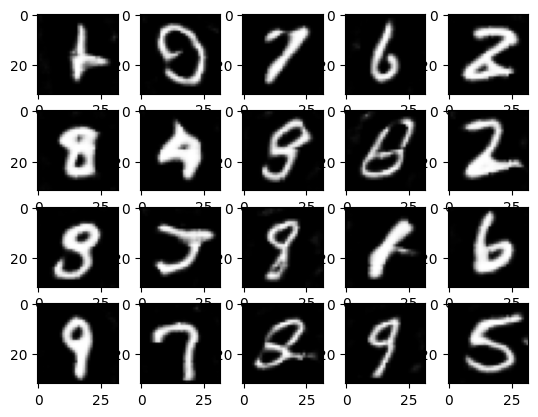

In [15]:
import matplotlib.pyplot as plt

noise_data = torch.randn(20, 100, 1, 1).to(device)
synthetic_data = net_G(noise_data)

for index, image in enumerate(synthetic_data):
    plt.subplot(4, 5, index+1)
    image = (image - image.min())/(image.max() - image.min())
    plt.imshow(image.squeeze().detach().cpu().numpy(), cmap='gray')
    
plt.show()